In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
import math
import time
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import tensorflow as tf
import os

import data_input
from convert_to_tfrecords import tags_meta

import resnet_model as model

model_checkpoint_path = '../save/resnet/model.ckpt-200'

num_tags = len(tags_meta)
gpuid = 0
raw_img_size = 256
model_img_size = 224
batch_size = 1
threhold = 0.5

os.environ['CUDA_VISIBLE_DEVICES'] = str(gpuid)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
graph = tf.Graph()
sess = tf.Session(config=config, graph=graph)


def load_model(graph, sess):
    with graph.as_default():
        raw_images_op = tf.placeholder(tf.float32, [batch_size, 256, 256])
        images = tf.expand_dims(raw_images_op, 3)
        labels = tf.placeholder(tf.float32, [batch_size, num_tags])
        # after reading raw images, first resize to fit the model, then normalize the data
        # resize
        images = tf.image.resize_images(images, np.array([model_img_size, model_img_size]))
        # normalize
        std_images = []
        for idx in range(batch_size):
            std_image = tf.image.per_image_standardization(images[idx,:,:,:])
            std_image = tf.expand_dims(std_image, 0)
            std_images.append(std_image)
        images = tf.concat(std_images, 0)

        # Build a Graph that computes the logits predictions from the
        # inference model.
        logits = model.inference(images, is_training=False, num_classes=num_tags)

        # Calculate predictions.
        prob_op = tf.sigmoid(logits)

        # Restore the moving average version of the learned variables for eval.
        saver = tf.train.Saver(tf.global_variables())

        print('load from pretrained model from')
        print(model_checkpoint_path)
        saver.restore(sess, model_checkpoint_path)
        
        return prob_op, raw_images_op
    

prob_op, raw_images_op = load_model(graph, sess)

load from pretrained model from
../save/resnet/model.ckpt-200
INFO:tensorflow:Restoring parameters from ../save/resnet/model.ckpt-200


/home/boyu/anaconda2/envs/tensorflow1.4/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


predit probability for the image
bcc:	0.000
beam off image:	0.000
circular beamstop:	0.000
diffuse high-q:	0.000
diffuse low-q:	1.000
fcc:	0.000
halo:	0.001
high background:	0.000
higher orders:	1.000
linear beamstop:	1.000
many rings:	0.957
polycrystalline:	0.014
ring:	1.000
strong scattering:	0.997
structure factor:	1.000
weak scattering:	0.000
wedge beamstop:	0.000


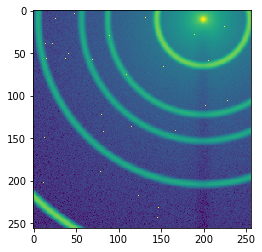

In [2]:
image = sio.loadmat('../data/example_images/00000040.mat')
image = image['detector_image']
# take the log to normalize the data
image = np.log(image) / np.log(1.0414)
image[np.isinf(image)] = 0
image = np.expand_dims(image, 0)
                
pred_prob = sess.run(prob_op, feed_dict={raw_images_op: image})
pred_label = pred_prob > threhold

plt.figure()
plt.imshow(image[0])

print('predit probability for the image')
for c_i in range(num_tags):
    print('%s:\t%.3f'%(tags_meta[c_i][1], pred_prob[0][c_i]))

#print('predicted labels')
#for c_i in range(num_tags):
#    if pred_label[0][c_i]:
#        print('%s'%(tags_meta[c_i][1])
    